In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
from IPython.display import clear_output

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import Training and Testing Data
#### Note: Here, testing data refers to what is normally called the validation data.

In [4]:
train_data = []
train_idx = []
test_data = []
test_idx = []

train_idx = list(range(2000))
test_idx = list(range(800))

for a in test_idx:
    full_i = np.loadtxt('./mco-validate/output' + str(a) + ('Rr.txt'))
    test_data.append([full_i[0],full_i[1],np.sum(full_i[2:len(full_i)]),full_i[2:len(full_i)]]) #coff layer 1, coff layer 2, reflectance sum, reflectance vs r

for b in train_idx:
    full_i = np.loadtxt('./mco/output' + str(b) + ('Rr.txt'))
    train_data.append([full_i[0],full_i[1],np.sum(full_i[2:len(full_i)]),full_i[2:len(full_i)]]) #coff layer 1, coff layer 2, reflectance sum, reflectance vs r    

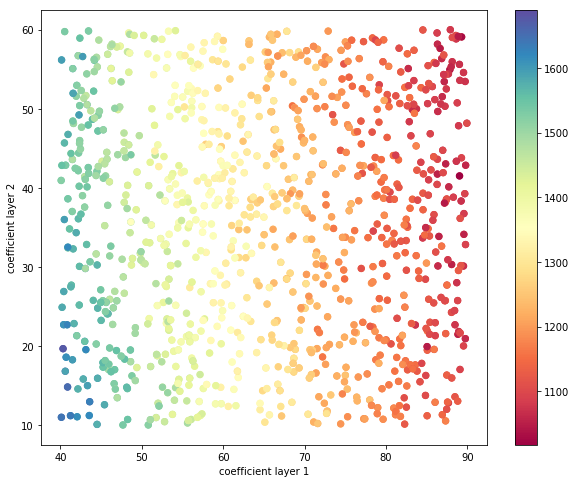

In [5]:
plt.scatter([i[0] for i in train_data], [i[1] for i in train_data], c=[i[2] for i in train_data], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.colorbar()

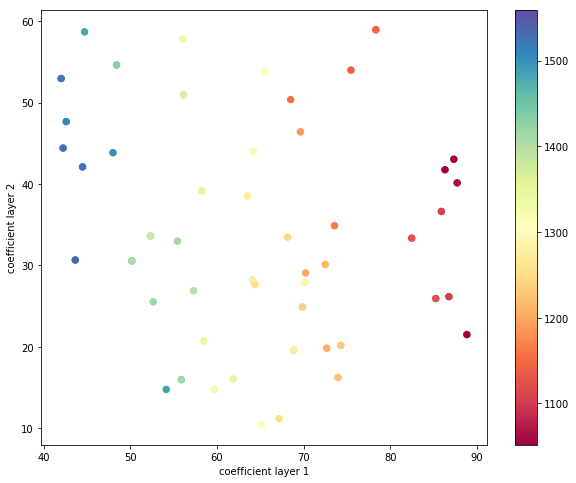

In [6]:
subset = 100
plt.scatter([(i[0]) for i in train_data[0:subset]], [(i[1]) for i in train_data[0:subset]], c=[(i[2]) for i in train_data[0:subset]], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.colorbar()

c:\users\noyolk\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: divide by zero encountered in log10


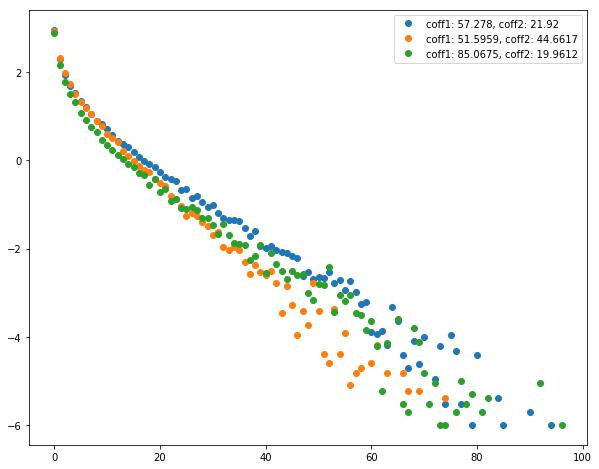

In [7]:
compare = []
for _ in range(3):
    compare.append(random.randint(0,len(train_data)))

for i in compare:
    plt.plot(np.log10(train_data[i][3]), 'o', label='coff1: ' + str(train_data[i][0]) + ', ' +  'coff2: ' + str(train_data[i][1]))   
plt.legend()

# Tensorflow Model
### to-do  :
1. test DNN if it works with 2 output neurons (it should? but test it just in case)
2. implement stochastic optimizer instead of all the data in every step
3. decide order and choice of activation function in output layer https://www.tensorflow.org/api_guides/python/nn
4. decide how to initialize weights https://www.tensorflow.org/api_guides/python/constant_op
5. decide on a good optimizer https://www.tensorflow.org/versions/r0.12/api_docs/python/train/optimizers
6. is there a better loss function other than root mean square? (?...! or ?...! in current model)  
7. maybe include total reflectance in input vector? possibly use total reflectance in a linear+deep model?
8. choose an appropriate loss function https://www.tensorflow.org/api_guides/python/contrib.losses
9. is the reflectance vs distance already included in our data or do we need to include it? The 'compare 3' graph above seems to suggest it's already included .. ?
10. enforce that training and test data are unique

### given reflectance[ ] guess Coff Layer 1 and Coff Layer 2 (1 hidden layer)

In [8]:
training_inputs = []
training_outputs = []
for i in train_data:
    training_outputs.append([i[0], i[1]])
    data_catch = []
    for j in i[3]:
        data_catch.append(j)
    training_inputs.append(data_catch)
    
testing_inputs = []
testing_outputs = []
for i in test_data:
    testing_outputs.append([i[0], i[1]])
    data_catch = []
    for j in i[3]:
        data_catch.append(j)
    testing_inputs.append(data_catch)

print('training input shape: ' + str(np.shape(np.array(training_inputs))))
print('training output shape: ' + str(np.shape(np.array(training_outputs))))

training input shape: (2000, 200)
training output shape: (2000, 2)


In [9]:
def random_sample(sample_length, list1, list2):
    len_list1 = np.shape(list1)[0]
    len_list2 = np.shape(list2)[0]
    if len_list1 != len_list2:
        return False
    else:
        sample_idx = random.sample(range(len_list1), sample_length)        
        s_list1 = [list1[i] for i in sample_idx]
        s_list2 = [list2[i] for i in sample_idx]
        return s_list1, s_list2

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

input_count = 200
inputs = tf.placeholder(tf.float32, shape=[None, input_count])

output_count = 2
desired_outputs = tf.placeholder(tf.float32, shape=[None, output_count])

In [11]:
weights_mean_HL1 = 0
weights_mean_OUT = 0

HL1_count = 5

weights_HL1 = tf.Variable(tf.truncated_normal([input_count, HL1_count], weights_mean_HL1))
biases_HL1 = tf.Variable(tf.zeros([HL1_count]))
HL1_out = tf.nn.relu(tf.matmul(inputs, weights_HL1) + biases_HL1)

weights_out = tf.Variable(tf.truncated_normal([HL1_count, output_count], weights_mean_OUT))
biases_out = tf.Variable(tf.zeros([output_count]))
net_out = tf.nn.relu(tf.matmul(HL1_out, weights_out) + biases_out)

In [12]:
error_function = tf.reduce_mean(tf.square(tf.sub(net_out, desired_outputs)))

train_step = tf.train.AdamOptimizer(0.0001).minimize(error_function)

In [13]:
tf.global_variables_initializer().run()

In [14]:
#restorer = tf.train.Saver()
#restorer.restore(sess, './model/1-hl-v3-8/1-hl-v3-8-model-3')

training step: 4000, loss:5.537286281585693
training step: 4200, loss:5.537436485290527
training step: 4400, loss:5.534218788146973
training step: 4600, loss:5.5337677001953125
training step: 4800, loss:5.535184860229492
training session:203.00383815104408s for 5000 steps
final loss:5.534751892089844


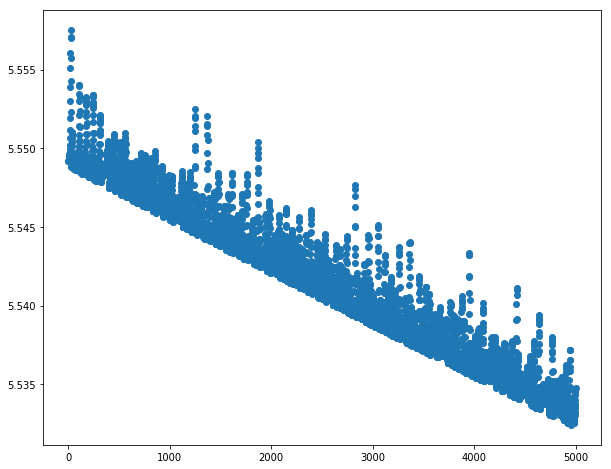

In [16]:
track_loss = []
train_length = 5000
#sample_length = 1806 #300 until loss ~ low 3 digits, high 2 digits -> 600 -> 1000 -> max


start_train_sess = time.clock()
for i in range(train_length):
    #sample_inputs, sample_outputs = random_sample(sample_length, training_inputs, training_outputs)
    _, loss = sess.run([train_step, error_function], 
                       feed_dict={inputs: np.array(training_inputs), desired_outputs: np.array(training_outputs)})
    
    if i%200 == 0:
        print ('training step: {0}, loss:{1}'.format(i, loss))            
        if i%1000 == 0:
            clear_output()
            print ('training step: {0}, loss:{1}'.format(i, loss))
    
    track_loss.append(loss)

print('training session:{0}s for {1} steps'.format((time.clock() - start_train_sess), train_length))
     
plt.plot(track_loss, 'o')
print('final loss:{0}'.format(track_loss[-1]))

91.625% of predictions are within 5.0 of the ground truth.


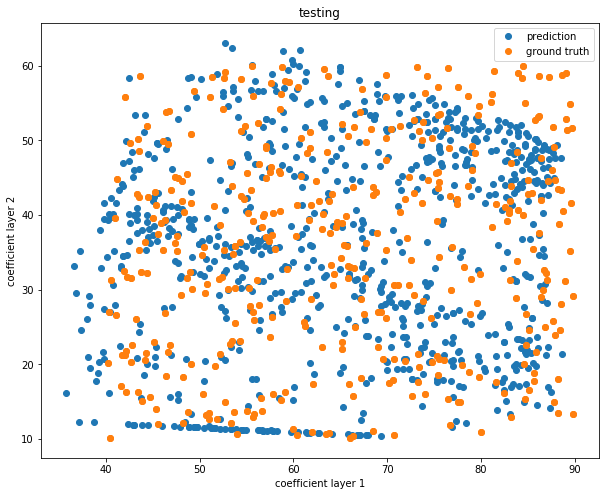

In [34]:
net_predict = sess.run(net_out, feed_dict={inputs: np.array(testing_inputs)})
#print(net_predict[0])
#print(net_predict[40])
#print(net_predict[80])
#print(net_predict[120])
#print(net_predict[160])
#print(net_predict[190])
#print(testing_outputs)

net_predict_x = []
net_predict_y = []
for i in net_predict:
    net_predict_x.append(i[0])
    net_predict_y.append(i[1])

testing_outputs_x = []
testing_outputs_y = []
for i in testing_outputs:
    testing_outputs_x.append(i[0])
    testing_outputs_y.append(i[1])
    
tolerance = 5.0
acc_total = 0
acc_pos = 0
for t_x, t_y, n_x, n_y in zip(testing_outputs_x, testing_outputs_y, net_predict_x, net_predict_y):
    acc_total += 1
    if (np.abs(t_x - n_x) <= tolerance) and (np.abs(t_y - n_y) <= tolerance):
        acc_pos += 1

print('{0}% of predictions are within {1} of the ground truth.'.format(((acc_pos/acc_total) * 100.0), tolerance))
        

plt.plot(net_predict_x, net_predict_y, 'o', label="prediction")
plt.plot(testing_outputs_x, testing_outputs_y, 'o', label="ground truth")
plt.xlabel('coefficient layer 1')
plt.ylabel('coefficient layer 2')
plt.title('testing')
plt.legend()

92.80000000000001% of predictions are within 5.0 of the ground truth.


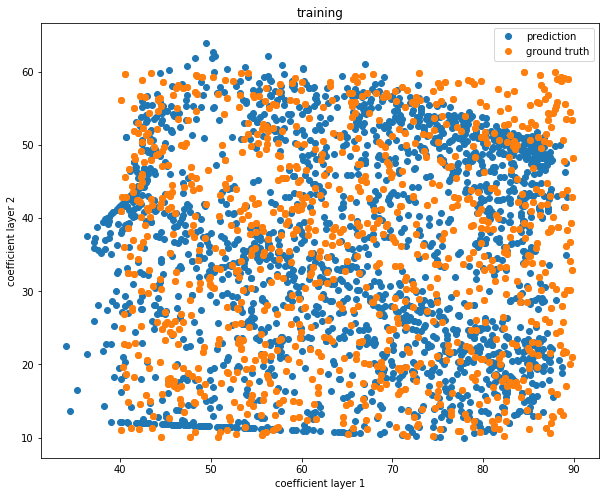

In [32]:
net_predict2 = sess.run(net_out, feed_dict={inputs: np.array(training_inputs)})
#print(net_predict2[0])
#print(net_predict2[40])
#print(net_predict2[80])
#print(net_predict2[120])
#print(net_predict2[160])
#print(net_predict2[190])
#print(testing_outputs)

net_predict_x2 = []
net_predict_y2 = []
for i in net_predict2:
    net_predict_x2.append(i[0])
    net_predict_y2.append(i[1])

training_outputs_x = []
training_outputs_y = []
for i in training_outputs:
    training_outputs_x.append(i[0])
    training_outputs_y.append(i[1])
    
tolerance = 5.0
acc_total = 0
acc_pos = 0
for t_x, t_y, n_x, n_y in zip(training_outputs_x, training_outputs_y, net_predict_x2, net_predict_y2):
    acc_total += 1
    if (np.abs(t_x - n_x) <= tolerance) and (np.abs(t_y - n_y) <= tolerance):
        acc_pos += 1

print('{0}% of predictions are within {1} of the ground truth.'.format(((acc_pos/acc_total) * 100.0), tolerance))
        

plt.plot(net_predict_x2, net_predict_y2, 'o', label="prediction")
plt.plot(training_outputs_x, training_outputs_y, 'o', label="ground truth")
plt.xlabel('coefficient layer 1')
plt.ylabel('coefficient layer 2')
plt.title('training')
plt.legend()

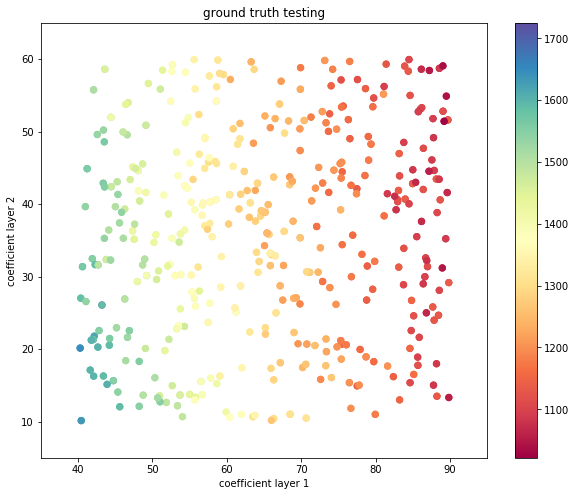

In [19]:
plt.scatter(testing_outputs_x, testing_outputs_y, c=[np.sum(i) for i in testing_inputs], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.xlim(35,95)
plt.ylim(5,65)
plt.title("ground truth testing")
plt.colorbar()

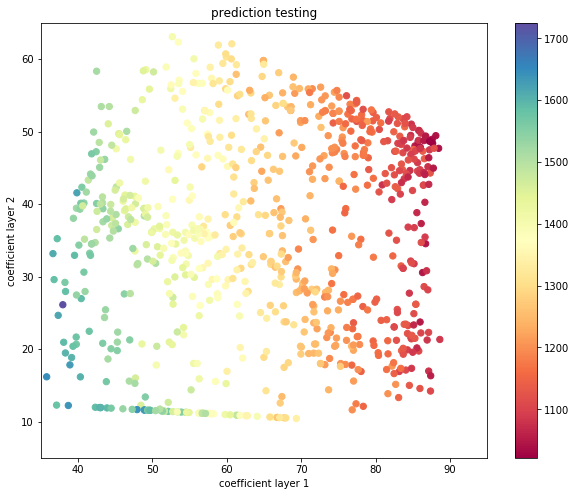

In [20]:
plt.scatter(net_predict_x, net_predict_y, c=[np.sum(i) for i in testing_inputs], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.xlim(35,95)
plt.ylim(5,65)
plt.title("prediction testing")
plt.colorbar()

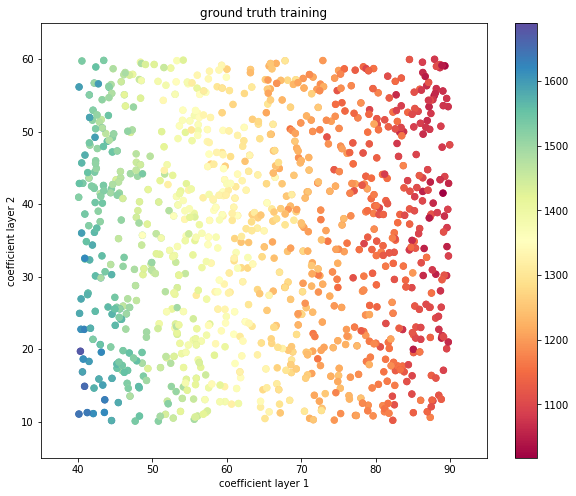

In [21]:
plt.scatter(training_outputs_x, training_outputs_y, c=[np.sum(i) for i in training_inputs], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.title("ground truth training")
plt.xlim(35,95)
plt.ylim(5,65)
plt.colorbar()

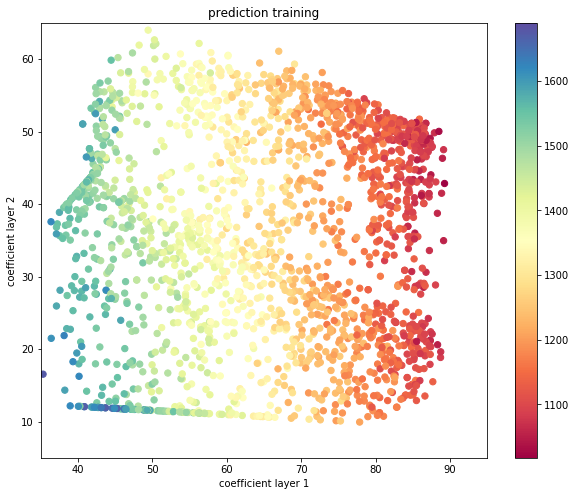

In [22]:
plt.scatter(net_predict_x2, net_predict_y2, c=[np.sum(i) for i in training_inputs], s=40, cmap=plt.cm.Spectral)
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.xlim(35,95)
plt.ylim(5,65)
plt.title("prediction training")
plt.colorbar()

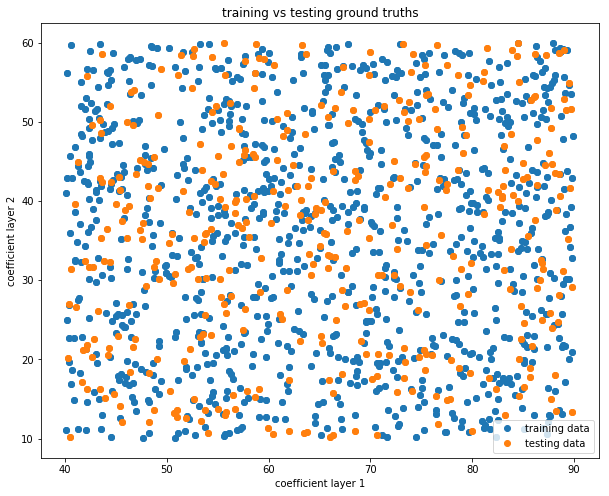

In [23]:
plt.plot([i[0] for i in train_data], [i[1] for i in train_data], 'o', label="training data")
plt.plot([i[0] for i in test_data], [i[1] for i in test_data], 'o', label="testing data")
plt.xlabel("coefficient layer 1")
plt.ylabel("coefficient layer 2")
plt.title("training vs testing ground truths")
plt.legend()

### Save Tensorflow Meta Graph and Manually Dump Weights and Biases Pickles
to import see: https://www.tensorflow.org/programmers_guide/meta_graph#import_a_metagraph

In [ ]:
weights_HL1_save = sess.run(weights_HL1, feed_dict={inputs: np.array(training_inputs)})
biases_HL1_save = sess.run(biases_HL1, feed_dict={inputs: np.array(training_inputs)})
weights_out_save = sess.run(weights_out, feed_dict={inputs: np.array(training_inputs)})
biases_out_save = sess.run(biases_out, feed_dict={inputs: np.array(training_inputs)})

pickle.dump (weights_HL1_save, open("./model/1-hl-v3-8-weights_HL1.pickle", "wb"))
pickle.dump (biases_HL1_save, open("./model/1-hl-v3-8-biases_HL1.pickle", "wb"))
pickle.dump (weights_out_save, open("./model/1-hl-v3-8-weights_out.pickle", "wb"))
pickle.dump (biases_out_save, open("./model/1-hl-v3-8-biases_out.pickle", "wb"))

In [ ]:
saver = tf.train.Saver(tf.global_variables())
saver.save(sess, './model/1-hl-v3-8-model', global_step = 3)
#meta_graph_def = tf.train.export_meta_graph(filename='./model/1-hl-v2-meta-graph.meta')

### Test model on data outside training range?

In [24]:
# general_data = []
# general_idx = []

# general_idx = list(range(400))

# for c in general_idx:    
#     full_i = np.loadtxt('./mco-general/output' + str(c) + ('Rr.txt'))
#     general_data.append([full_i[0],full_i[1],np.sum(full_i[2:len(full_i)]),full_i[2:len(full_i)]]) #coff layer 1, coff layer 2, reflectance sum, reflectance vs r    

In [25]:
# general_inputs = []
# general_outputs = []
# for i in general_data:
#     general_outputs.append([i[0], i[1]])
#     data_catch = []
#     for j in i[3]:
#         data_catch.append(j)
#     general_inputs.append(data_catch)

# print('general input shape: ' + str(np.shape(np.array(general_inputs))))
# print('general output shape: ' + str(np.shape(np.array(general_outputs))))

general input shape: (400, 200)
general output shape: (400, 2)


In [35]:
# net_predict3 = sess.run(net_out, feed_dict={inputs: np.array(general_inputs)})

# net_predict_x3 = []
# net_predict_y3 = []
# for i in net_predict3:
#     net_predict_x3.append(i[0])
#     net_predict_y3.append(i[1])

# general_outputs_x = []
# general_outputs_y = []
# for i in general_outputs:
#     general_outputs_x.append(i[0])
#     general_outputs_y.append(i[1])
    
# tolerance = 1.0
# acc_total = 0
# acc_pos = 0
# for t_x, t_y, n_x, n_y in zip(general_outputs_x, general_outputs_y, net_predict_x3, net_predict_y3):
#     acc_total += 1
#     if (np.abs(t_x - n_x) <= tolerance) and (np.abs(t_y - n_y) <= tolerance):
#         acc_pos += 1

# print('{0}% of predictions are within {1} of the ground truth.'.format(((acc_pos/acc_total) * 100.0), tolerance))
        

# plt.plot(net_predict_x3, net_predict_y3, 'o', label="prediction")
# plt.plot(general_outputs_x, general_outputs_y, 'o', label="ground truth")
# plt.xlabel('coefficient layer 1')
# plt.ylabel('coefficient layer 2')
# plt.title('predictions outside training range')
# plt.legend()